In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

(train_examples, validation_examples), info = tfds.load(
    'cifar100', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]']
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [3]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 256

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Mobilenet V2


In [4]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))
feature_extractor.trainable = False

In [5]:
mobilenet = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(100)
])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

mobilenet.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 20
history_mobilenet = mobilenet.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[callback])

Epoch 1/20
157/157 [==============================] - 69s 339ms/step - loss: 3.1547 - accuracy: 0.2953 - val_loss: 1.5738 - val_accuracy: 0.5707
Epoch 2/20
157/157 [==============================] - 53s 334ms/step - loss: 1.4174 - accuracy: 0.6132 - val_loss: 1.3834 - val_accuracy: 0.6130
Epoch 3/20
157/157 [==============================] - 53s 333ms/step - loss: 1.2038 - accuracy: 0.6641 - val_loss: 1.3160 - val_accuracy: 0.6283
Epoch 4/20
157/157 [==============================] - 53s 334ms/step - loss: 1.0793 - accuracy: 0.6947 - val_loss: 1.2964 - val_accuracy: 0.6367
Epoch 5/20
157/157 [==============================] - 53s 334ms/step - loss: 1.0001 - accuracy: 0.7174 - val_loss: 1.2745 - val_accuracy: 0.6393
Epoch 6/20
157/157 [==============================] - 53s 334ms/step - loss: 0.9341 - accuracy: 0.7354 - val_loss: 1.2572 - val_accuracy: 0.6441
Epoch 7/20
157/157 [==============================] - 53s 334ms/step - loss: 0.8684 - accuracy: 0.7545 - val_loss: 1.2493 - val_ac

Text(0.5, 1.0, 'Train and Val Loss')

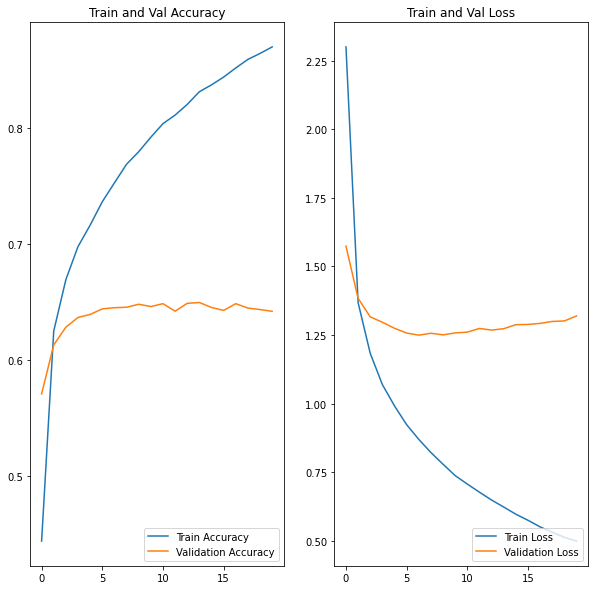

In [6]:
acc = history_mobilenet.history["accuracy"]
val_acc = history_mobilenet.history["val_accuracy"]

loss = history_mobilenet.history["loss"]
val_loss = history_mobilenet.history["val_loss"]

epochs_range = range(len(history_mobilenet.history["loss"]))

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Train and Val Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Train and Val Loss")

## Custom Model

In [7]:
IMAGE_RES = 32

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 256

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [8]:
def custom_model():
    model = models.Sequential() # Create Sequential Model
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3))) # Convolution Layer 1
    model.add(layers.Activation('selu')) 
    model.add(BatchNormalization()) 
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3))) # Convolution Layer 2
    model.add(layers.Activation('selu')) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same')) 
    model.add(BatchNormalization())

    model.add(layers.Conv2D(128, (5, 5), padding='same')) # Convolution Layer 3
    model.add(layers.Activation('selu')) 
    model.add(BatchNormalization())
    model.add(layers.Conv2D(128, (5, 5), padding='same')) # Convolution Layer 4
    model.add(layers.Activation('selu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2))) 
    model.add(layers.Dropout(0.4))
    model.add(BatchNormalization())

    model.add(layers.Conv2D(256, (7, 7), padding='same')) # Convolution Layer 5
    model.add(layers.Activation('selu')) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same')) 
    model.add(layers.Dropout(0.4))
    model.add(BatchNormalization())

    model.add(layers.Conv2D(512, (7, 7), padding='same')) # Convolution Layer 6
    model.add(layers.Activation('selu')) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(BatchNormalization())

    model.add(layers.Flatten()) # Flatten layer to feed to the Dense Layer

    # Fully Connected Layer 
    model.add(layers.Dense(100,
                    kernel_regularizer=regularizers.l2(0.01),
                    activity_regularizer=regularizers.l1(0.01)))

    model.add(layers.Activation('softmax')) # Softmax Function to Classify 
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

model = custom_model()
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 20
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[callback])

Epoch 1/20
157/157 [==============================] - 25s 137ms/step - loss: 6.9432 - accuracy: 0.0732 - val_loss: 5.8849 - val_accuracy: 0.0241
Epoch 2/20
157/157 [==============================] - 21s 131ms/step - loss: 4.6417 - accuracy: 0.2116 - val_loss: 4.8571 - val_accuracy: 0.0958
Epoch 3/20
157/157 [==============================] - 21s 131ms/step - loss: 3.8791 - accuracy: 0.3243 - val_loss: 3.9820 - val_accuracy: 0.2737
Epoch 4/20
157/157 [==============================] - 21s 130ms/step - loss: 3.4921 - accuracy: 0.3999 - val_loss: 3.4131 - val_accuracy: 0.4003
Epoch 5/20
157/157 [==============================] - 21s 130ms/step - loss: 3.1731 - accuracy: 0.4654 - val_loss: 3.1465 - val_accuracy: 0.4499
Epoch 6/20
157/157 [==============================] - 21s 130ms/step - loss: 2.9383 - accuracy: 0.5200 - val_loss: 3.0867 - val_accuracy: 0.4628
Epoch 7/20
157/157 [==============================] - 21s 131ms/step - loss: 2.7515 - accuracy: 0.5636 - val_loss: 2.8817 - val_ac

Text(0.5, 1.0, 'Train and Val Loss')

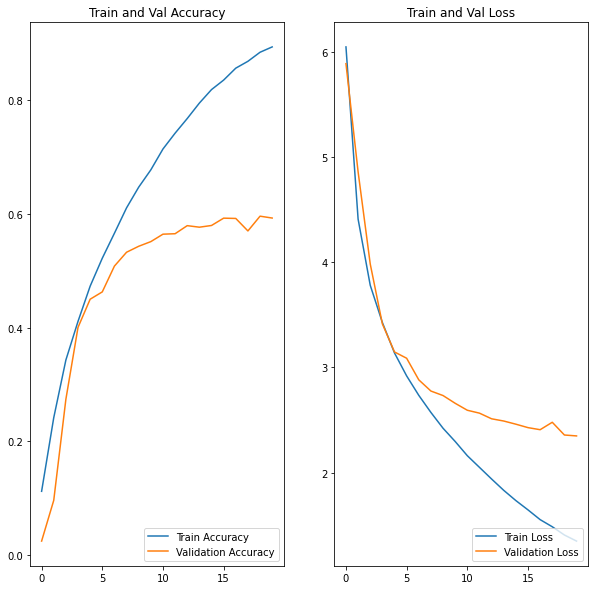

In [9]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(history.history["loss"]))

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Train and Val Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Train and Val Loss")